In [29]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

from scipy.signal import butter, filtfilt
from scipy.stats import entropy

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

import joblib
import os

# =======================
# GLOBAL CONSTANTS
# =======================
FS = 50                  # sampling frequency (Hz)
WINDOW_SIZE = 128        # 2.56 seconds
STEP_SIZE = 64           # 50% overlap
CONFIDENCE_THRESHOLD = 0.7


In [30]:
def butter_lowpass(cutoff, fs=FS, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low")
    return b, a


def lowpass_filter(signal, cutoff):
    b, a = butter_lowpass(cutoff)
    return filtfilt(b, a, signal)


def remove_gravity(acc):
    gravity = lowpass_filter(acc, cutoff=0.3)
    return acc - gravity


def sliding_window(signal, window_size=WINDOW_SIZE, step_size=STEP_SIZE):
    windows = []
    for i in range(0, len(signal) - window_size, step_size):
        windows.append(signal[i:i + window_size])
    return np.array(windows)


In [31]:
def extract_features(window):
    """
    Extract statistical features from a 1D signal window
    """
    return [
        np.mean(window),
        np.std(window),
        np.min(window),
        np.max(window),
        np.sum(window ** 2) / len(window),   # energy
        entropy(np.abs(window) + 1e-6)
    ]


def extract_all_features(acc_x_w, acc_y_w, acc_z_w,
                         gyro_x_w, gyro_y_w, gyro_z_w):
    """
    Combine features from accelerometer and gyroscope windows
    Order is FIXED and must not change
    """

    features = []

    for i in range(len(acc_x_w)):
        row = []

        # Accelerometer features
        row.extend(extract_features(acc_x_w[i]))
        row.extend(extract_features(acc_y_w[i]))
        row.extend(extract_features(acc_z_w[i]))

        # Gyroscope features
        row.extend(extract_features(gyro_x_w[i]))
        row.extend(extract_features(gyro_y_w[i]))
        row.extend(extract_features(gyro_z_w[i]))

        features.append(row)

    return np.array(features)


In [32]:
# ===============================
# BUILD DATASET FROM REAL-WORLD DATA
# ===============================

BASE_DIR = Path("../data/real_world/raw")

# detect all known persons (exclude 'unknown')
person_dirs = [
    d for d in BASE_DIR.iterdir()
    if d.is_dir() and d.name != "unknown"
]

print("Detected known persons:")
for d in person_dirs:
    print(" -", d.name)

# assign numeric labels
label_map = {person_dir.name: idx for idx, person_dir in enumerate(person_dirs)}
reverse_label_map = {v: k for k, v in label_map.items()}

X_list = []
y_list = []

for person_dir in person_dirs:
    print(f"\nProcessing {person_dir.name}")

    # load data
    acc_df = pd.read_csv(person_dir / "./acc.csv")
    gyro_df = pd.read_csv(person_dir / "gyro.csv")

    # -------- Accelerometer preprocessing --------
    acc_x = remove_gravity(acc_df["x"].values)
    acc_y = remove_gravity(acc_df["y"].values)
    acc_z = remove_gravity(acc_df["z"].values)

    # -------- Gyroscope preprocessing --------
    gyro_x = gyro_df["x"].values
    gyro_y = gyro_df["y"].values
    gyro_z = gyro_df["z"].values

    # -------- Windowing --------
    acc_x_w = sliding_window(acc_x)
    acc_y_w = sliding_window(acc_y)
    acc_z_w = sliding_window(acc_z)

    gyro_x_w = sliding_window(gyro_x)
    gyro_y_w = sliding_window(gyro_y)
    gyro_z_w = sliding_window(gyro_z)

    # -------- Synchronize windows --------
    n_windows = min(
        len(acc_x_w), len(acc_y_w), len(acc_z_w),
        len(gyro_x_w), len(gyro_y_w), len(gyro_z_w)
    )

    if n_windows == 0:
        print("  ⚠️ Not enough data, skipping")
        continue

    acc_x_w = acc_x_w[:n_windows]
    acc_y_w = acc_y_w[:n_windows]
    acc_z_w = acc_z_w[:n_windows]

    gyro_x_w = gyro_x_w[:n_windows]
    gyro_y_w = gyro_y_w[:n_windows]
    gyro_z_w = gyro_z_w[:n_windows]

    # -------- Feature extraction --------
    X_person = extract_all_features(
        acc_x_w, acc_y_w, acc_z_w,
        gyro_x_w, gyro_y_w, gyro_z_w
    )

    y_person = np.full(len(X_person), label_map[person_dir.name])

    X_list.append(X_person)
    y_list.append(y_person)

    print(f"  Windows used: {n_windows}")
    print(f"  Feature shape: {X_person.shape}")

# -------- Final dataset --------
X = np.vstack(X_list)
y = np.concatenate(y_list)

print("\nFinal dataset created")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Class distribution:", Counter(y))


Detected known persons:
 - person1
 - person2
 - person3
 - person4
 - person5
 - person6

Processing person1
  Windows used: 32
  Feature shape: (32, 36)

Processing person2
  Windows used: 22
  Feature shape: (22, 36)

Processing person3
  Windows used: 27
  Feature shape: (27, 36)

Processing person4
  Windows used: 23
  Feature shape: (23, 36)

Processing person5
  Windows used: 28
  Feature shape: (28, 36)

Processing person6
  Windows used: 23
  Feature shape: (23, 36)

Final dataset created
X shape: (155, 36)
y shape: (155,)
Class distribution: Counter({0: 32, 4: 28, 2: 27, 3: 23, 5: 23, 1: 22})


In [33]:
# ===============================
# MODEL TRAINING & ACCURACY
# ===============================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# define model
model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

# cross-validation strategy
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# evaluate accuracy
cv_scores = cross_val_score(
    model,
    X,
    y,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())
print("Std Deviation:", cv_scores.std())


Cross-Validation Accuracy Scores: [0.70967742 0.5483871  0.61290323 0.58064516 0.64516129]
Mean Accuracy: 0.6193548387096774
Std Deviation: 0.05549887269059761


In [34]:
# ===============================
# TRAIN FINAL MODEL & SAVE
# ===============================

import os
import joblib
from sklearn.ensemble import RandomForestClassifier

# define final model (same config as CV)
final_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

# train on full dataset
final_model.fit(X, y)

print("Final model trained on all known persons")


MODEL_PATH = "../models/gait_model2.pkl"
joblib.dump(final_model, MODEL_PATH)
joblib.dump(reverse_label_map, "../models/label_map_realworld.pkl")

print(f"Model saved at: {MODEL_PATH}")


Final model trained on all known persons
Model saved at: ../models/gait_model2.pkl


In [35]:
# load back to verify
loaded_model = joblib.load(MODEL_PATH)
print("Loaded model type:", type(loaded_model))


Loaded model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [36]:
# ===============================
# AUTHENTICATION: UNKNOWN PERSON
# ===============================

def predict_unknown_person(unknown_dir):
    # load unknown data
    acc_df = pd.read_csv(unknown_dir / "acc.csv")
    gyro_df = pd.read_csv(unknown_dir / "gyro.csv")

    # -------- preprocess accelerometer --------
    acc_x = remove_gravity(acc_df["x"].values)
    acc_y = remove_gravity(acc_df["y"].values)
    acc_z = remove_gravity(acc_df["z"].values)

    # -------- preprocess gyroscope --------
    gyro_x = gyro_df["x"].values
    gyro_y = gyro_df["y"].values
    gyro_z = gyro_df["z"].values

    # -------- windowing --------
    acc_x_w = sliding_window(acc_x)
    acc_y_w = sliding_window(acc_y)
    acc_z_w = sliding_window(acc_z)

    gyro_x_w = sliding_window(gyro_x)
    gyro_y_w = sliding_window(gyro_y)
    gyro_z_w = sliding_window(gyro_z)

    # -------- synchronize windows --------
    n = min(
        len(acc_x_w), len(acc_y_w), len(acc_z_w),
        len(gyro_x_w), len(gyro_y_w), len(gyro_z_w)
    )

    if n == 0:
        return "ACCESS DENIED", None, 0.0

    acc_x_w = acc_x_w[:n]
    acc_y_w = acc_y_w[:n]
    acc_z_w = acc_z_w[:n]

    gyro_x_w = gyro_x_w[:n]
    gyro_y_w = gyro_y_w[:n]
    gyro_z_w = gyro_z_w[:n]

    # -------- feature extraction --------
    X_unknown = extract_all_features(
        acc_x_w, acc_y_w, acc_z_w,
        gyro_x_w, gyro_y_w, gyro_z_w
    )

    # -------- prediction --------
    probs = final_model.predict_proba(X_unknown)
    preds = final_model.classes_[np.argmax(probs, axis=1)]
    confs = np.max(probs, axis=1)

    # -------- confidence-based filtering --------
    valid_preds = [
        (p, c) for p, c in zip(preds, confs)
        if c >= CONFIDENCE_THRESHOLD
    ]

    if len(valid_preds) == 0:
        return "ACCESS DENIED", None, np.mean(confs)

    # majority vote
    final_label = Counter([p for p, _ in valid_preds]).most_common(1)[0][0]
    avg_conf = np.mean([c for _, c in valid_preds])

    return "ACCESS GRANTED", reverse_label_map[final_label], avg_conf


In [42]:
UNKNOWN_DIR = Path("../data/real_world/raw/unknown")

status, person, confidence = predict_unknown_person(UNKNOWN_DIR)

print("Decision   :", status)
print("Person     :", person)
print("Confidence :", round(confidence, 3))


Decision   : ACCESS GRANTED
Person     : person1
Confidence : 0.862


In [43]:
def get_confidences(person_dir):
    acc_df = pd.read_csv(person_dir / "acc.csv")
    gyro_df = pd.read_csv(person_dir / "gyro.csv")

    acc_x = remove_gravity(acc_df["x"].values)
    acc_y = remove_gravity(acc_df["y"].values)
    acc_z = remove_gravity(acc_df["z"].values)

    gyro_x = gyro_df["x"].values
    gyro_y = gyro_df["y"].values
    gyro_z = gyro_df["z"].values

    acc_x_w = sliding_window(acc_x)
    acc_y_w = sliding_window(acc_y)
    acc_z_w = sliding_window(acc_z)

    gyro_x_w = sliding_window(gyro_x)
    gyro_y_w = sliding_window(gyro_y)
    gyro_z_w = sliding_window(gyro_z)

    n = min(
        len(acc_x_w), len(acc_y_w), len(acc_z_w),
        len(gyro_x_w), len(gyro_y_w), len(gyro_z_w)
    )

    if n == 0:
        return np.array([])

    X_person = extract_all_features(
        acc_x_w[:n], acc_y_w[:n], acc_z_w[:n],
        gyro_x_w[:n], gyro_y_w[:n], gyro_z_w[:n]
    )

    probs = final_model.predict_proba(X_person)
    confs = np.max(probs, axis=1)

    return confs


In [44]:
import matplotlib.pyplot as plt

# choose one known person
known_person_dir = person_dirs[0]   # e.g., person_01
unknown_person_dir = Path("../data/real_world/raw/unknown")

known_conf = get_confidences(known_person_dir)
unknown_conf = get_confidences(unknown_person_dir)

print("Known windows:", len(known_conf))
print("Unknown windows:", len(unknown_conf))


Known windows: 32
Unknown windows: 32


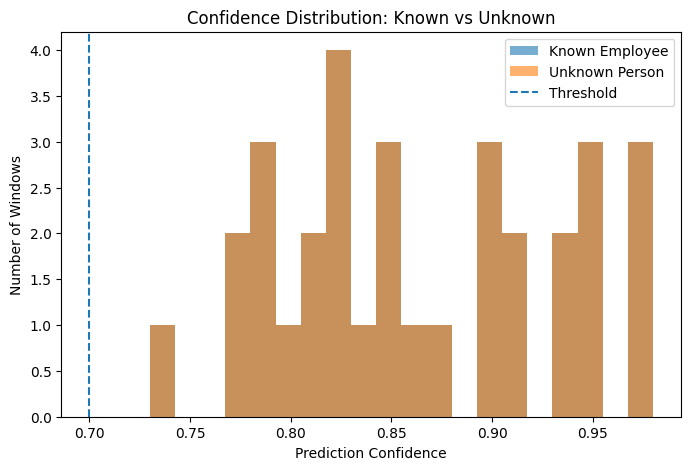

In [45]:
plt.figure(figsize=(8,5))

plt.hist(known_conf, bins=20, alpha=0.6, label="Known Employee")
plt.hist(unknown_conf, bins=20, alpha=0.6, label="Unknown Person")

plt.axvline(CONFIDENCE_THRESHOLD, linestyle="--", label="Threshold")

plt.xlabel("Prediction Confidence")
plt.ylabel("Number of Windows")
plt.title("Confidence Distribution: Known vs Unknown")
plt.legend()
plt.show()


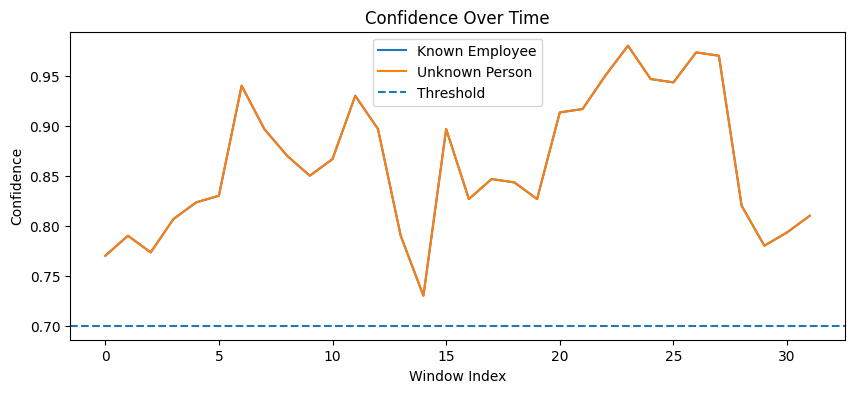

In [46]:
plt.figure(figsize=(10,4))

plt.plot(known_conf, label="Known Employee")
plt.plot(unknown_conf, label="Unknown Person")

plt.axhline(CONFIDENCE_THRESHOLD, linestyle="--", label="Threshold")

plt.xlabel("Window Index")
plt.ylabel("Confidence")
plt.title("Confidence Over Time")
plt.legend()
plt.show()
